# Smoothing Time Series with Neural Networks

In [1]:
import numpy as np
import scipy

import matplotlib.pyplot as plt

import time

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
%config InlineBackend.figure_format='retina'

# Finally, print nice Latex labels for figures. 
# Comment these out if you don't want to wait for the tex to compile, or don't
# want to bother get tex working. 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# also, we should manually set the dpi for figures so they look good
# if saving figs, you should do so at a much higher dpi!
dpi = 300

In [2]:
# [ignore warnings about CUDA thanks to https://github.com/tensorflow/tensorflow/issues/54499]
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# import Keras (I have done it through tensorflow just to avoid installing extra stuff but if you want to change 
# it go right ahead) 
import tensorflow as tf
# tf.keras. ... 

In this short demo (really an afterword to my time series kriging notebook) we see how noisy measurements of a function $z(t)$ can be used to construct a neural network
$$
t\mapsto \text{NN}(t) \approx z(t) .
$$
That is, we're in the business of interpolation/data smoothing. The artificial example studied here is the same one from my time series kriging demo. 

Of course, unlike in kriging, neural nets give us no confidence intervals! This is a major limitation. Additionally, since neural networks contain many more hyperparameters than are involved in kriging, one has to do a lot more tuning to get a prediction. Finally, at least for this simple time series problem, kriging (as implemented in sklearn) is a lot faster. With all this in mind, perhaps it's better to think of this demo as an introduction to the basics of neural networks through Keras for those familiar with interpolation/kriging, rather than an awe-inspiring demonstration of the power of neural nets. 

First, we simulate our data like we did last time. 

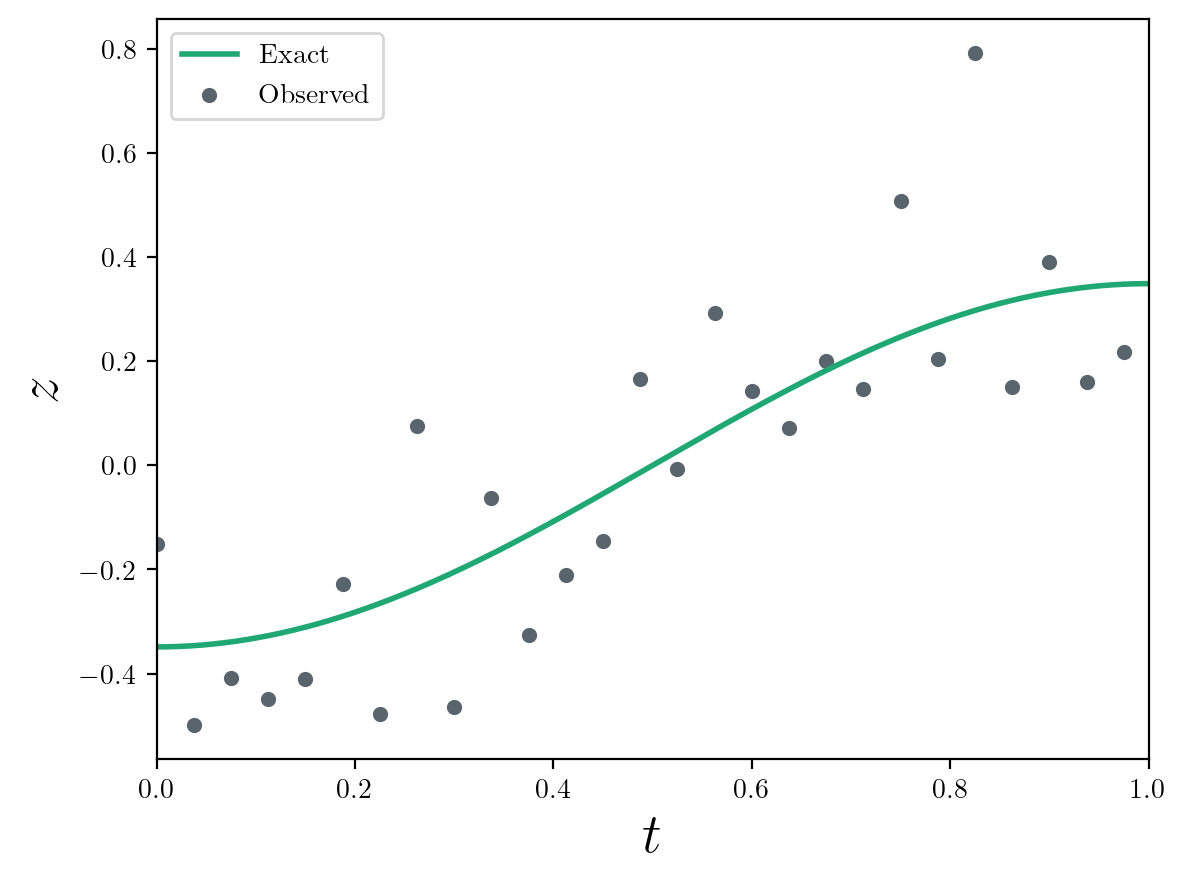

In [3]:
# Define the artifical data & plot it 
num_pts = 16001
t = np.linspace(0,1, num=num_pts, endpoint=True)
np.random.seed(32) # fix random seed
R = np.random.normal(loc=0., scale=1., size=1)
phi = 0. 
omega = 0.5
z = R*np.cos(omega*2.*np.pi*t + phi) 
z_noisy = z + 0.2*np.random.randn(len(t))
sample_freq = 600
z_obs = z_noisy[::sample_freq]
t_obs = t[::sample_freq]

plt.plot(t,z,color='xkcd:jade',linewidth='2',label='Exact')
plt.scatter(t_obs, z_obs, color="xkcd:slate gray",  s=20, label="Observed")
plt.xlabel('$t$', fontsize='20')
plt.ylabel('$z$', fontsize='20')
plt.xlim([0.,1.])
plt.legend()
plt.show()

Now, we define our network architecture. We use a dense/fully connected network whose particular depth and neuron counts were determined through experimentation. Since our objective is data *smoothing*, we ought to choose *smooth* activation functions. To get all the benefits of ReLU without sacrificing derivatives, we can use the SiLU activation function 
$$
\text{SiLU}(x) = \frac{x}{1+e^{-x}}. 
$$

In [4]:
#tf.keras.backend.clear_session()

tf.random.set_seed(32)

nn = 4

# note how we use the SMOOTH silu activation func here, since our objective is data smoothing! 

model = tf.keras.Sequential() # init the network 
model.add(tf.keras.layers.InputLayer(shape=[1,])) # define the input layer: "shape" = "shape of the inputs" 
model.add(tf.keras.layers.Flatten()) # flattens the input array so it becomes a vector
model.add(tf.keras.layers.Dense(nn, activation="silu")) # nn = number of neurons, activation = activation fnc
model.add(tf.keras.layers.Dense(2*nn, activation="silu")) 
model.add(tf.keras.layers.Dense(nn, activation="silu")) 
model.add(tf.keras.layers.Dense(2*nn, activation="silu")) 
model.add(tf.keras.layers.Dense(nn, activation="silu")) 
model.add(tf.keras.layers.Dense(1, activation="silu")) # output

In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165 (660.00 B)

 Trainable params: 165 (660.00 B)

 Non-trainable params: 0 (0.00 B)

Now we train the model with an MSE loss (a natural loss for a smoothing/regression problem) using the Adam optimizer. This is faster than vanilla SGD but, depending on the initialization, may give "falsely optimal kicks" that increase the number of epochs we need. 

In [6]:
#opt = tf.keras.optimizers.SGD(learning_rate = 0.4)
opt = tf.keras.optimizers.Adam(learning_rate = 1e-2, use_ema = True)
model.compile(loss="mean_squared_error",
              optimizer=opt,
              metrics=["mse"])

In [7]:
# because we don't have much data, we'll just use one batch
n_epochs = 350
history = model.fit(t_obs, z_obs, epochs=n_epochs, verbose=0, batch_size = len(t_obs))

Let's make sure the loss is decreasing...

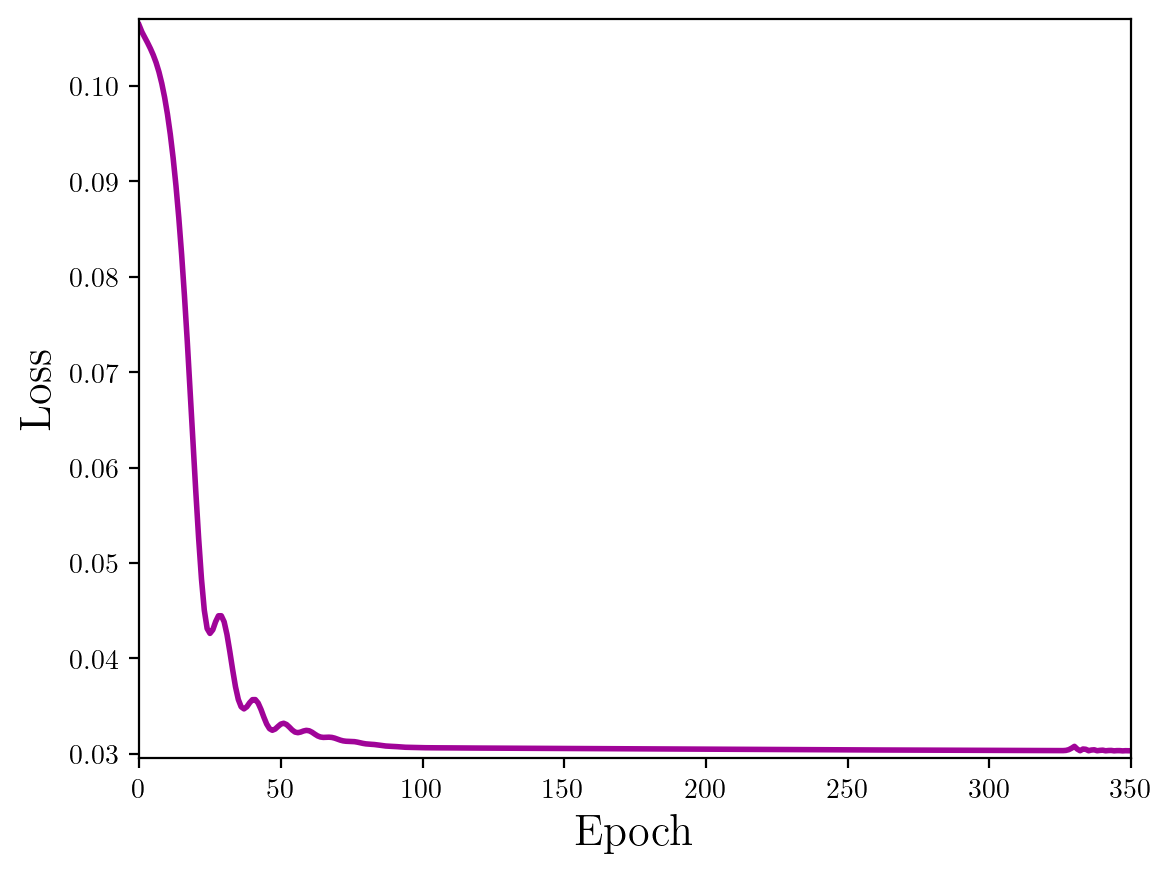

In [8]:
loss_hist = history.history['loss'] 

plt.plot(range(0,n_epochs), loss_hist, color='xkcd:barney purple', linewidth=2)
plt.xlim([0,n_epochs])
plt.ylim([0.0295, 0.107])
plt.xlabel("Epoch", fontsize='16')
plt.ylabel("Loss", fontsize='16')

plt.show()

Finally, we use our model to perform predictions. 

In [9]:
t_pred = t
z_pred = model.predict(t_pred)

501/501 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step


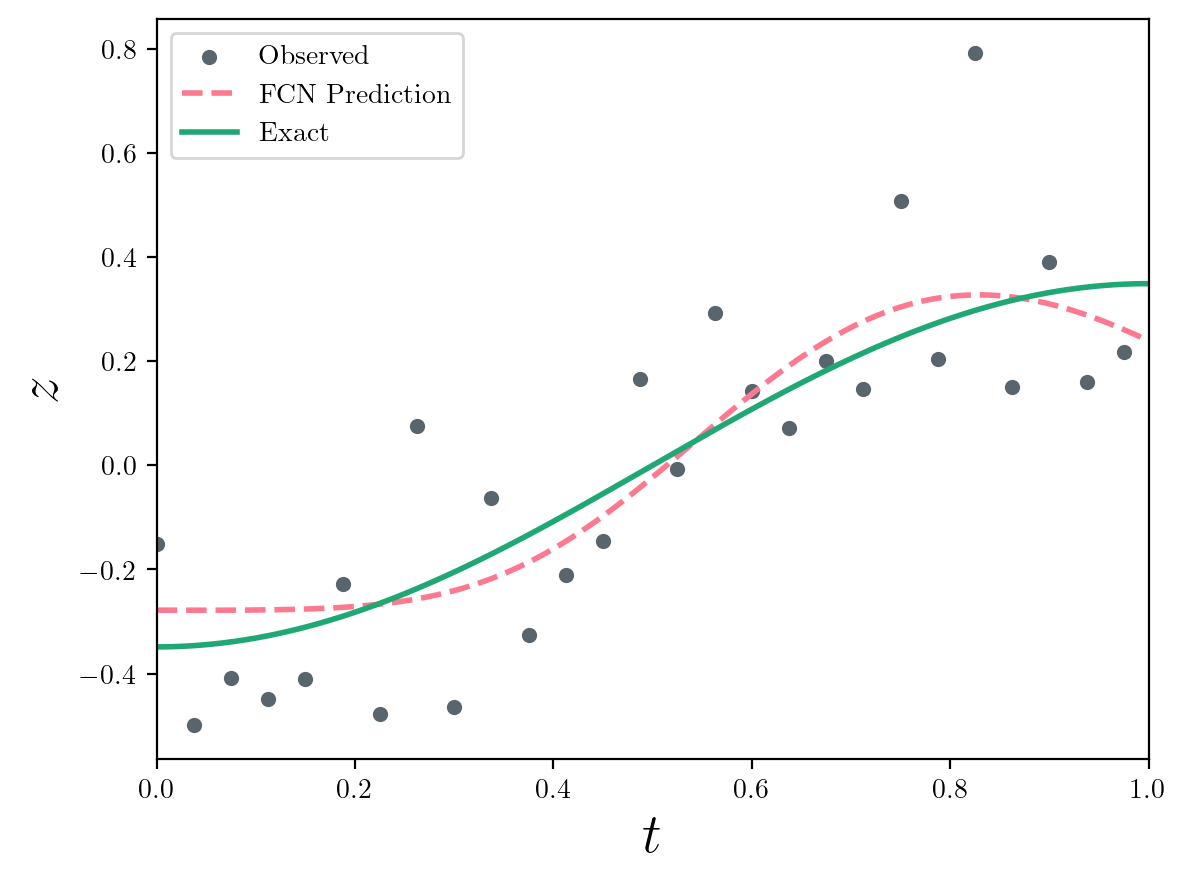

In [10]:
plt.scatter(t_obs, z_obs, color="xkcd:slate gray",  s=20, label="Observed")
plt.plot(t_pred, z_pred, linestyle='dashed', color = 'xkcd:carnation', linewidth='2', label='FCN Prediction')
plt.plot(t,z,color='xkcd:jade',linewidth='2',label='Exact')
plt.xlabel('$t$', fontsize='20')
plt.ylabel('$z$', fontsize='20')
plt.xlim([0.,1.])
plt.legend()
plt.show()

The performance is pretty good (you may have to train for a few more epochs depending on if the optimizer made a bad move or not), & similar to what we saw with kriging. However, the lack of error bars is a major strike against the neural net approach to this problem.  